## Useful imports

In [1]:
!pip install segmentation_models_pytorch
! git clone https://github.com/Bjarten/early-stopping-pytorch.git
! mv ./early-stopping-pytorch ./lib

     |████████████████████████████████| 106 kB 12.9 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 4.2 MB/s  eta 0:00:01
     |████████████████████████████████| 2.2 MB 59.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 26.7 MB/s eta 0:00:01
     |████████████████████████████████| 268 kB 55.7 MB/s eta 0:00:01
     |████████████████████████████████| 53 kB 2.0 MB/s  eta 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=f19154b7ba235d61a67d14effe41c97343f1c29e8b243db309e0af137cbfbddf
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60963 sha256=bf7ede948f5965d968b53469f92fe14abdfeb339ffddc979f8ffe7ac4553a9bf
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficie

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, sampler
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torchvision
import cv2
import re
import segmentation_models_pytorch as smp
from lib.pytorchtools import *

# **Creating Dataset**

### Creating cumstom Pytorch dataset

In [3]:
class NerveDataset(Dataset):
    def __init__(self, directory, pytorch=True, is_test=False):
        super().__init__()
        
        # Loop through the files in 'directory' folder and combine, into a dictionary, the masks
        self.files = []
        for file_name in directory.iterdir():
            
            if 'mask' in str(file_name):
                continue
                
            self.files.append(self.combine_files(file_name))
            
        # Sorting files list
        self.files = sorted(self.files, key=lambda file: int(re.search(r'\d+', str(file['image'])).group(0)))
        #print(self.files)
        
        self.pytorch = pytorch
        self.resize = torchvision.transforms.Resize((224,224),interpolation=Image.NEAREST)
        self.is_test = is_test
        
    def combine_files(self, file_name: Path):
        
        files = {
            'image': file_name, 
            'mask': '..' + str(file_name).split('.')[2] + '_mask.tif',
        }

        return files
                                       
    def __len__(self):
        
        return len(self.files)
     
    def open_as_array(self, idx, invert=False):
        
        raw_image = self.resize(Image.open(self.files[idx]['image']))
        raw_image = raw_image = np.stack([ np.array(raw_image) ], axis=2)
    
        if invert:
            raw_image = raw_image.transpose((2,0,1))
    
        # normalize
        return (raw_image / np.iinfo(raw_image.dtype).max)
    

    def open_mask(self, idx, add_dims=False):
        
        raw_mask = self.resize(Image.open(self.files[idx]['mask']))
        raw_mask = np.array(raw_mask)
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch), dtype=torch.float32)
        
        if not self.is_test:    
            y = torch.tensor(self.open_mask(idx, add_dims=True), dtype=torch.torch.float32)
            return x, y
        
        return x
    
    def open_as_pil(self, idx):
        
        arr = 256*self.open_as_array(idx)
        
        return Image.fromarray(arr.astype(np.uint8), 'L')
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())

        return s


In [4]:
images_path = Path('../input/ultrasound-nerve-segmentation/train')
data = NerveDataset(images_path)
len(data)

5635

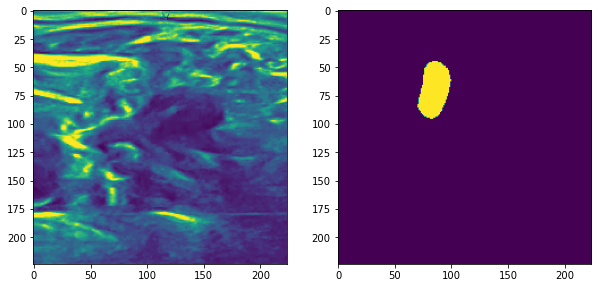

In [5]:
fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(data.open_as_array(5))
ax[1].imshow(data.open_mask(5))

### Split data to train and validation sets

In [6]:
split_rate = 0.7
train_ds_len = int(len(data) * split_rate)
valid_ds_len = len(data) - train_ds_len

train_ds, valid_ds = torch.utils.data.random_split(data, (train_ds_len, valid_ds_len))

print(f'Train dataset length: {len(train_ds)}\n')
print(f'Validation dataset length: {len(valid_ds)}\n')
print(f'All data length: {len(data)}\n')

Train dataset length: 3944

Validation dataset length: 1691

All data length: 5635



# Model configuring

In [7]:
from segmentation_models_pytorch import utils
# Model
unet = model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,
    classes=1,
    activation = "sigmoid"
)
# unet = model = smp.UnetPlusPlus(
#     encoder_name="resnet34",
#     encoder_weights=None,
#     in_channels=1,
#     classes=1,
#     activation = "sigmoid"
# )
# unet = model = smp.FPN(
#     encoder_name="resnet34",
#     encoder_weights=None,
#     in_channels=1,
#     classes=1,
#     activation = "sigmoid"
# )
# unet = model = smp.PSPNet(
#     encoder_name="resnet34",
#     encoder_weights=None,
#     in_channels=1,
#     classes=1,
#     activation = "sigmoid"
# )
# unet = model = smp.DeepLabV3(
#     encoder_name="resnet34",
#     encoder_weights=None,
#     in_channels=1,
#     classes=1,
#     activation = "sigmoid"
# )
# unet = model = smp.DeepLabV3Plus(
#     encoder_name="resnet34",
#     encoder_weights=None,
#     in_channels=1,
#     classes=1,
#     activation = "sigmoid"
# )


# Device type
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Params
learning_rate = 0.001
epochs = 9
metrics = [utils.metrics.IoU()]
# Loss & optimizer
loss_function = utils.losses.DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Scheduler & stopper
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
stopper = EarlyStopping(patience=3)
# Train & vallidation functions
train_epoch = utils.train.TrainEpoch(model,
                                          loss=loss_function,
                                          optimizer=optimizer,
                                          metrics=metrics,
                                          device=device,
                                          verbose=True)
val_epoch = utils.train.ValidEpoch(model,
                                          loss=loss_function,
                                          metrics=metrics,
                                          device=device,
                                          verbose=True)

# Data loaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=16, shuffle=True)

# Model training

In [8]:
train_loss = []
val_loss = []

train_acc = []
val_acc = []

for epoch in range(epochs):
    # training proccess
    print('\nEpoch: {}'.format(epoch))
    train_log = train_epoch.run(train_dl)
    val_log = val_epoch.run(valid_dl)

    scheduler.step()

    train_loss.append(train_log[loss_function.__name__])
    val_loss.append(val_log[loss_function.__name__])

    train_acc.append(train_log['iou_score']) 
    val_acc.append(val_log['iou_score'])

    stopper(val_log[loss_function.__name__], model)
    if stopper.early_stop:
#         break
        pass


Epoch: 0
valid: 100%|██████████| 106/106 [00:48<00:00,  2.18it/s, dice_loss - 0.4767, iou_score - 0.3644]

Epoch: 1
valid: 100%|██████████| 106/106 [00:18<00:00,  5.69it/s, dice_loss - 0.4501, iou_score - 0.3888]

Epoch: 2
valid: 100%|██████████| 106/106 [00:18<00:00,  5.70it/s, dice_loss - 0.5108, iou_score - 0.3303]
EarlyStopping counter: 1 out of 3

Epoch: 3
valid: 100%|██████████| 106/106 [00:18<00:00,  5.77it/s, dice_loss - 0.4111, iou_score - 0.4266]

Epoch: 4
valid: 100%|██████████| 106/106 [00:18<00:00,  5.70it/s, dice_loss - 0.4347, iou_score - 0.4044]
EarlyStopping counter: 1 out of 3

Epoch: 5
valid: 100%|██████████| 106/106 [00:18<00:00,  5.68it/s, dice_loss - 0.4061, iou_score - 0.4316]

Epoch: 6
valid: 100%|██████████| 106/106 [00:18<00:00,  5.75it/s, dice_loss - 0.3968, iou_score - 0.4469]

Epoch: 7
valid: 100%|██████████| 106/106 [00:18<00:00,  5.69it/s, dice_loss - 0.3873, iou_score - 0.4509]

Epoch: 8
valid: 100%|██████████| 106/106 [00:18<00:00,  5.70it/s, dice_loss

# Train results

In [9]:
print(train_loss)

[0.5818319504077615, 0.43118686907687176, 0.4156381630221843, 0.39862502417583684, 0.3780509197277578, 0.36424844274636725, 0.35932145596515797, 0.33348209848288113, 0.3241853465435479]


Text(0.5, 1.0, 'Train and validation losses for each epoch')

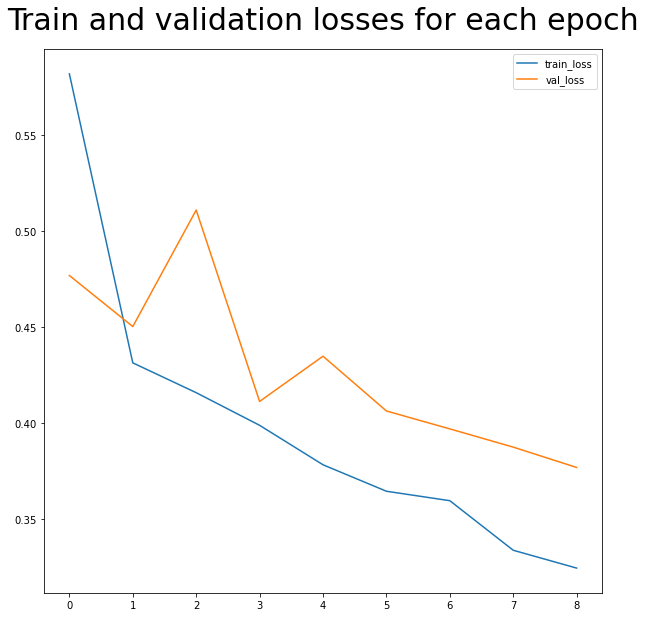

In [10]:
plt.figure(figsize=(10, 10))
plt.plot(range(len(train_loss)), train_loss, label='train_loss')
plt.plot(range(len(val_loss)), val_loss, label='val_loss')
plt.legend()
plt.title('Train and validation losses for each epoch', fontdict={'fontsize': 30,}, pad=20)

Text(0.5, 1.0, 'Train and validation accuracy for each epoch')

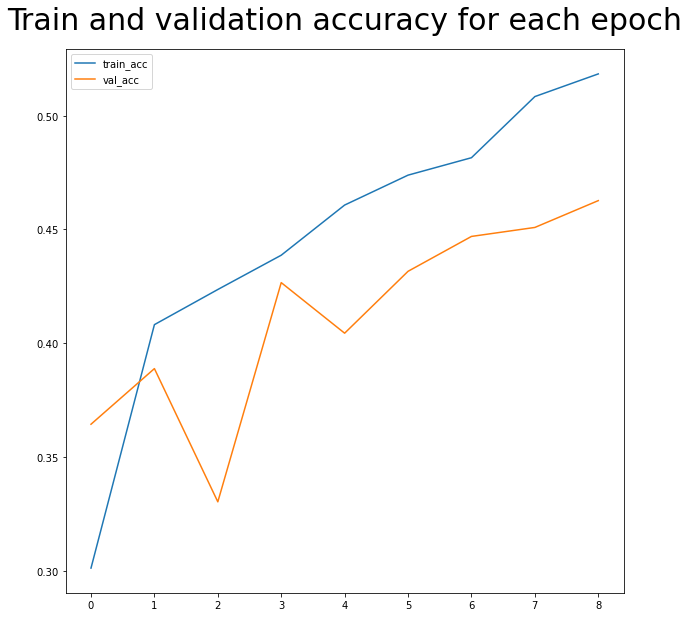

In [11]:
plt.figure(figsize=(10, 10))
plt.plot(range(len(train_acc)), train_acc, label='train_acc')
plt.plot(range(len(val_acc)), val_acc, label='val_acc')
plt.legend()
plt.title('Train and validation accuracy for each epoch', fontdict={'fontsize': 30,}, pad=20)

In [12]:
print('val_acc',val_acc)

val_acc [0.3644079045164136, 0.3888489410000927, 0.3303110666643336, 0.42663585408697663, 0.4044139698008608, 0.431606664831908, 0.4469349263413998, 0.45088267382585767, 0.4626700346762279]


In [13]:
test_images_path = Path('../input/ultrasound-nerve-segmentation/test')
test_data = NerveDataset(test_images_path, is_test=True)
test_dl = DataLoader(test_data, batch_size=1, shuffle=False)
len(test_data)

5508

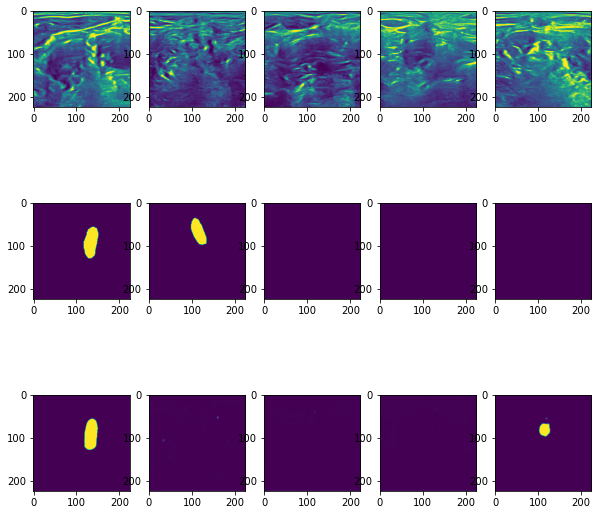

In [14]:
unet.train(False)

dataiter = iter(valid_dl)

fx, ax = plt.subplots(3, 5, figsize=(10,10))

for i in range(5):
    images, masks = dataiter.next()
    
    ax[0][i].imshow(np.transpose(images[0], (1, 2, 0)))
    ax[1][i].imshow(np.transpose(masks[0], (1, 2, 0)))
    
    if torch.cuda.is_available():
        images = images.cuda()
    
    pred = unet(images)
    pred = pred.cpu().detach().numpy()
    # print(pred)
    ax[2][i].imshow(np.transpose(pred[0], (1, 2, 0)))
    
    #ax[3][i].imshow(pred[0][1] - pred[0][0])
    
    
    

In [15]:
# def rle_encoding(x):
#     dots = np.where(x.T.flatten()==1)[0]
#     run_lengths = []
#     prev = -2
#     for b in dots:
#         if (b>prev+1): run_lengths.extend((b+1, 0))
#         run_lengths[-1] += 1
#         prev = b
#     return run_lengths

In [16]:
# encodings = []
# counter = 0

# # fx, ax = plt.subplots(1, 5, figsize=(10,10))

# for image in test_dl:
    
#     if torch.cuda.is_available():
#         image = image.cuda()
        
#     pr_mask = unet(image)
    
#     pr_mask = pr_mask[0]
    
#     pr_mask = pr_mask.squeeze().cpu().detach().numpy().round().astype(np.uint8)
#     pr_mask = cv2.resize(pr_mask,(580,420), interpolation=cv2.INTER_CUBIC)

#     encodings.append(rle_encoding(pr_mask))
    
# #     print(f'Image: {counter} ')
    
#     counter += 1
# #     ax[counter].imshow(pr_mask)
# #     if counter == 5:
# #         break


In [17]:
# len(encodings)

In [18]:
# df_submission = pd.DataFrame(columns=["img", "pixels"])
# for i, encoding in enumerate(encodings):
#     pixels = ' '.join(map(str, encoding))
#     df_submission.loc[i] = [str(i+1), pixels]

# df_submission.to_csv('./submission.csv', index=False)
# print('Done!')